# Molecular Hydrogen (H2) Exemplar
## Step 0: Import various libraries

In [2]:
# Imports for QSCOUT
import jaqalpaq
from jaqalpaq.core import circuitbuilder
from jaqalpaq.core.circuit import normalize_native_gates
from jaqalpaq import emulator

from qscout.v1 import native_gates
from qscout.v1 import noisy
from qscout.v1.std import stretched
from jaqalpaq.core.stretch import stretched_gates

# Imports for basic mathematical functionality
from math import pi
import numpy as np

# Imports for OpenFermion(-PySCF)
import openfermion as of
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

# Import for VQE optimizer
from scipy import optimize

# Import IonSim Error Model
from qscout.v1.ionsim_stretched import IonSimErrorModel
from qscout.v1.ion_interpolator_stretched import SingleQubitTargetOp, MSTargetOp, adjust_time
from qscout.v1.ion_interpolator_stretched import fixed_up_interpolator

# %load_ext snakeviz

## Step 1: SCF calculation to assemble the second-quantized Hamiltonian

In [3]:
# Set the basis set, spin, and charge of the H2 molecule
basis = 'sto-3g'
multiplicity = 1
charge = 0

# Set calculation parameters
run_scf = 1
run_fci = 1
delete_input = True
delete_output = False

# Generate molecule at some bond length (0.7474 Angstroms here)
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., 0.7474))]
molecule = MolecularData(
    geometry, basis, multiplicity, charge,    
    filename='./H2_sto-3g_single_0.7474') #Set file location of data

# Run pyscf to generate new molecular data for sto-3g H2
molecule = run_pyscf(molecule,
                     run_scf=run_scf,
                     run_fci=run_fci,
                     verbose=False)

print("Bond Length in Angstroms: {}".format(0.7474))
print("FCI (Exact) energy in Hartrees: {}".format(molecule.fci_energy))

Bond Length in Angstroms: 0.7474
FCI (Exact) energy in Hartrees: -1.137175710240685


## Step 2: Convert the fermionic Hamiltonian to a qubit Hamiltonian

In [4]:
# Get the fermionic Hamiltonian for H2 and map it using the BK encoding
hamiltonian = molecule.get_molecular_hamiltonian()
hamiltonian_ferm = of.get_fermion_operator(hamiltonian)
hamiltonian_bk = of.bravyi_kitaev(hamiltonian_ferm)

# Define Pauli strings that appear in the reduced two-qubit Hamiltonian
terms = [[None, None], ['Z', None], [None, 'Z'], ['Z', 'Z'], ['X', 'X'], ['Y', 'Y']]

# Calculate effective coefficients for the reduced two-qubit Hamiltonian
# Derivation follows arXiv:1803.10238v2 appendix A-2
fs = hamiltonian_bk.terms #Old coefficients from OpenFermion Hamiltonian
c0 = (fs[()] + fs[(1, 'Z'),] + fs[(1, 'Z'), (3, 'Z'),]).real
c1 = (fs[(0, 'Z'),] + fs[(0, 'Z'), (1, 'Z'),]).real
c2 = (fs[(2, 'Z'),] + fs[(1, 'Z'), (2, 'Z'), (3, 'Z'),]).real
c3 = (fs[(0, 'Z'), (2, 'Z'),] + fs[(0, 'Z'), (1, 'Z'), (2, 'Z'),] + fs[(0, 'Z'), (2, 'Z'), (3, 'Z'),] + fs[(0, 'Z'), (1, 'Z'), (2, 'Z'), (3, 'Z')]).real
c4 = (fs[(0,'X'), (1, 'Z'), (2, 'X'),] + fs[(0, 'X'), (1, 'Z'), (2, 'X'), (3, 'Z'),]).real
c5 = (fs[(0, 'Y'), (1, 'Z'), (2, 'Y'),] + fs[(0, 'Y'), (1, 'Z'), (2, 'Y'), (3, 'Z'),]).real
cs = [c0, c1, c2, c3, c4, c5] #New coefficients are linear combinations of old coefficients

gates = native_gates.NATIVE_GATES.copy()
gates.update(stretched.NATIVE_GATES)

## Step 3: Define UCC Ansatz circuit in JaqalPaq

In [5]:
def ansatz(theta, term, stretch):
    builder = circuitbuilder.CircuitBuilder(native_gates=gates)

    # Define constants +-pi/2
    pi2 = builder.let('pi2', pi/2)
    npi2 = builder.let('npi2', -pi/2)

    # Create a qubit register
    q = builder.register('q', 2)

    # Prepare the Hartree Fock state
    builder.gate('prepare_all')
    builder.gate('Px_stretched', q[0], stretch)

    # Apply the UCC Ansatz exp[-i*theta(X1 Y0)]
    builder.gate('MS_stretched', q[1], q[0], 0, pi2, stretch)
    builder.gate('Rz_stretched', q[1], theta, stretch)
    builder.gate('MS_stretched', q[1], q[0], 0, npi2, stretch)

    # Change basis for measurement depending on term
    for j, qubit in enumerate(term):
        if qubit == 'X':
            builder.gate('Sy_stretched', ('array_item', q, j), stretch)
            builder.gate('Px_stretched', ('array_item', q, j), stretch)
        if qubit == 'Y':
            builder.gate('Sxd_stretched', ('array_item', q, j), stretch)

    builder.gate('measure_all')

    circuit = builder.build()

    return circuit

In [6]:
def ansatz_sampling(theta, stretch, sample_noise):
    term_probs = []
    for i in range(len(terms)):
        if sample_noise:
            probs = np.zeros(4)
            circuit = ansatz(theta, terms[i], stretch)
            sim_result = emulator.run_jaqal_circuit(circuit, backend=IonSimErrorModel(2, v0=[1e-3, 1.0, 0], sigmas=[0, 0, 0], sample=True, datadir='stretched')) #Run circuit on emulator
            # sim_result = emulator.run_jaqal_circuit(circuit, backend=backend) #Run circuit on emulator
            sim_probs = sim_result.subcircuits[0].probability_by_int
            sample = np.random.choice(4, size=n_samples, p=sim_probs)
            for count in sample:
                probs[count] += 1 #Increment state counter
            probs = probs/n_samples #Determine probabilities from sampling
            term_probs += [probs] #Combine lists of probs of each term in Hamiltonian
                
        else: #Exact solution without sampling
            circuit = ansatz(theta, terms[i], stretch)
            sim_result = emulator.run_jaqal_circuit(circuit, backend=IonSimErrorModel(2, v0=[1e-3, 1.0, 0], sigmas=[0, 0, 0], sample=True, datadir='stretched')) #Run circuit on emulator
            # sim_result = emulator.run_jaqal_circuit(circuit, backend=backend) #Run circuit on emulator
            sim_probs = sim_result.subcircuits[0].probability_by_int
            term_probs += [sim_probs]

    return term_probs

## Step 4: Define functions to calculate energy expectation value of Ansatz state

In [7]:
# Calculate energy of one term of the Hamiltonian for one possible state
def term_energy(term, state, coefficient, prob):
    parity = 1
    for i in range(len(term)):
        #Change parity if state is occupied and is acted on by a pauli operator
        if term[i] != None and state[i] == '1':
            parity = -1*parity
    return coefficient*prob*parity

# Calculate energy of the molecule for a given value of theta
def make_calculate_energy(stretch, sample_noise):
    def calculate_energy(theta):
        energy = 0
        probs = ansatz_sampling(theta[0], stretch, sample_noise) #Convert tuple (from optimization) to float for circuit
        for i in range(len(terms)): #For each term in the hamiltonian
            for j in range(len(probs[0])): #For each possible state
                term = terms[i]
                state = '{0:02b}'.format(j)[::-1] #convert state to binary (# of qubits)
                coefficient = cs[i].real
                prob = probs[i][j]
                #print(term, state, coefficient, prob)
                energy += term_energy(term, state, coefficient, prob)
        return energy
    return calculate_energy

## Step 5: Minimize the energy expectation value in  𝜃

In [8]:
#%%snakeviz
# Minimize the energy using classical optimization
#error= [1e-3, 1e-2, 1e-2]
#error= [1e-3, 0, 0]
#error= [0, 1e-2, 0]
#backend=noisy.SNLToy1(2, depolarization=error[0], rotation_error=error[1], phase_error=error[2], stretched_gates='add')

n_samples=1
result = optimize.minimize(fun=make_calculate_energy(1.0, True), x0=[0.01], method="COBYLA") #Can use "L-BFGS-B" instead
print('Control: {}'.format(result.fun))

print(molecule.fci_energy-result.fun)

phi/pi, theta/pi = 0.0 1.0
... computing gate_R... phi/pi, theta/pi =  0.0 1.0
phi/pi, theta/pi = 0.5 1.0
... computing gate_R... phi/pi, theta/pi =  0.5 1.0
phi/pi, theta/pi = 0.0 0.5
... computing gate_R... phi/pi, theta/pi =  0.0 0.5
phi/pi, theta/pi = 0.5 0.5
... computing gate_R... phi/pi, theta/pi =  0.5 0.5
phi/pi, theta/pi = 1.0 0.5
... computing gate_R... phi/pi, theta/pi =  1.0 0.5
phi/pi, theta/pi = 1.5 0.5
... computing gate_R... phi/pi, theta/pi =  1.5 0.5
target: phi/pi, theta/pi = 0.0 0.5
... computing gate_MS... phi/pi, theta/pi =  0.0 0.5


/Users/bruzic/Documents/Projects/pyGSTi/pygsti/objects/evaltree.py:192: UserWarning: Created an evaluation tree that is inefficient: tree-size > 3 * #circuits !
This is likely due to the fact that the circuits being simulated do not have a
periodic structure. Consider using a different forward simulator (e.g. MapForwardSimulator).
  _warnings.warn(("Created an evaluation tree that is inefficient: tree-size > %d * #circuits !\n"


target: phi/pi, theta/pi = 1.0 0.5
... computing gate_MS... phi/pi, theta/pi =  1.0 0.5


/Users/bruzic/Documents/Projects/pyGSTi/pygsti/objects/evaltree.py:192: UserWarning: Created an evaluation tree that is inefficient: tree-size > 10 * #circuits !
This is likely due to the fact that the circuits being simulated do not have a
periodic structure. Consider using a different forward simulator (e.g. MapForwardSimulator).
  _warnings.warn(("Created an evaluation tree that is inefficient: tree-size > %d * #circuits !\n"


Control: -1.2979508959626802
0.16077518572199523


## Step 6: Loop over previous steps to calculate ground state energy at different bond lengths

In [9]:
# Set the basis set, spin, and charge of the H2 molecule
basis = 'sto-3g'
multiplicity = 1
charge = 0

# Set calculation parameters
run_scf = 1
run_fci = 1
delete_input = True
delete_output = False

stretch_factors = [1.0, 1.25, 1.5, 2.0]
optimized_energies = [[], [], [], []]
exact_energies = []

# Loop over bond lengths from 0.3 to 1.3 angstroms
sample_noise=False
n_samples = 1 # Sample circuit
n_pts = 11 # Number of points
bond_lengths = np.linspace(0.3,1.3,n_pts)
for diatomic_bond_length in bond_lengths:
    # Generate molecule at some bond length
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity, charge,
        description=str(round(diatomic_bond_length, 2)),
        filename='./H2_sto-3g_single_dissociation')

    # Run pyscf to generate new molecular data for sto-3g H2
    molecule = run_pyscf(molecule,
                     run_scf=run_scf,
                     run_fci=run_fci,
                     verbose=False)
    
    # Get the fermionic Hamiltonian for H2 and map it into qubits using the BK encoding
    hamiltonian = molecule.get_molecular_hamiltonian()
    hamiltonian_ferm = of.get_fermion_operator(hamiltonian)
    hamiltonian_bk = of.bravyi_kitaev(hamiltonian_ferm)

    # Define Pauli strings that appear in the reduced two-qubit Hamiltonian
    terms = [[None, None], ['Z', None], [None, 'Z'], ['Z', 'Z'], ['X', 'X'], ['Y', 'Y']]

    # Calculate effective coefficients for the reduced two-qubit Hamiltonian
    # Derivation follows arXiv:1803.10238v2 appendix A-2
    fs = hamiltonian_bk.terms #Old coefficients from OpenFermion Hamiltonian
    c0 = (fs[()] + fs[(1, 'Z'),] + fs[(1, 'Z'), (3, 'Z'),]).real
    c1 = (fs[(0, 'Z'),] + fs[(0, 'Z'), (1, 'Z'),]).real
    c2 = (fs[(2, 'Z'),] + fs[(1, 'Z'), (2, 'Z'), (3, 'Z'),]).real
    c3 = (fs[(0, 'Z'), (2, 'Z'),] + fs[(0, 'Z'), (1, 'Z'), (2, 'Z'),] + fs[(0, 'Z'), (2, 'Z'), (3, 'Z'),] + fs[(0, 'Z'), (1, 'Z'), (2, 'Z'), (3, 'Z')]).real
    c4 = (fs[(0,'X'), (1, 'Z'), (2, 'X'),] + fs[(0, 'X'), (1, 'Z'), (2, 'X'), (3, 'Z'),]).real
    c5 = (fs[(0, 'Y'), (1, 'Z'), (2, 'Y'),] + fs[(0, 'Y'), (1, 'Z'), (2, 'Y'), (3, 'Z'),]).real
    cs = [c0, c1, c2, c3, c4, c5] #New coefficients are linear combinations of old coefficients

    # Minimize the expectation value of the energy using a classical optimizer (COBYLA)
    exact_energies.append(molecule.fci_energy)
    print("R={}\t Exact Energy: {}".format(str(round(diatomic_bond_length, 2)), molecule.fci_energy))
    for i in range(len(stretch_factors)):
        stretch=stretch_factors[i]
        result = optimize.minimize(fun=make_calculate_energy(stretch, sample_noise), x0=[0.01], method="COBYLA")
        optimized_energies[i].append(result.fun)
        print("R={}\t Optimized Energy: {}\t Stretch: {}".format(str(round(diatomic_bond_length, 2)), result.fun, stretch_factors[i]))
    print('\n')
    

R=0.3	 Exact Energy: -0.6018037107656862
R=0.3	 Optimized Energy: -0.5925429882651106	 Stretch: 1.0
phi/pi, theta/pi = 0.0 1.0
... computing gate_R... phi/pi, theta/pi =  0.0 1.0
target: phi/pi, theta/pi = 0.0 0.5
... computing gate_MS... phi/pi, theta/pi =  0.0 0.5
target: phi/pi, theta/pi = 1.0 0.5
... computing gate_MS... phi/pi, theta/pi =  1.0 0.5
phi/pi, theta/pi = 0.5 0.5
... computing gate_R... phi/pi, theta/pi =  0.5 0.5
phi/pi, theta/pi = 1.0 0.5
... computing gate_R... phi/pi, theta/pi =  1.0 0.5
R=0.3	 Optimized Energy: -0.5873508209292067	 Stretch: 1.25
phi/pi, theta/pi = 0.0 1.0
... computing gate_R... phi/pi, theta/pi =  0.0 1.0
target: phi/pi, theta/pi = 0.0 0.5
... computing gate_MS... phi/pi, theta/pi =  0.0 0.5
target: phi/pi, theta/pi = 1.0 0.5
... computing gate_MS... phi/pi, theta/pi =  1.0 0.5
phi/pi, theta/pi = 0.5 0.5
... computing gate_R... phi/pi, theta/pi =  0.5 0.5
phi/pi, theta/pi = 1.0 0.5
... computing gate_R... phi/pi, theta/pi =  1.0 0.5
R=0.3	 Optimiz

In [10]:
zero_noise = np.zeros(len(optimized_energies[0]))

# Compute zero-noise value
def extrapolation(coeffs, values):
    a = np.ones((len(coeffs), len(coeffs)))
    for i in range(1, len(coeffs)):
        for j in range(len(coeffs)):
            # Raise ith row to ith power
            a[i][j] = (coeffs[j] ** i)  
    b = np.zeros(len(coeffs))
    b[0] = 1
    
    gamma = np.linalg.solve(a, b)
    return(values @ gamma)

for i in range(len(optimized_energies[0])):
    values = []
    for j in range(len(stretch_factors)):
        values.append(optimized_energies[j][i])
    zero_noise[i] = extrapolation(stretch_factors, values)

## Step 7: Plot the dissociation curve

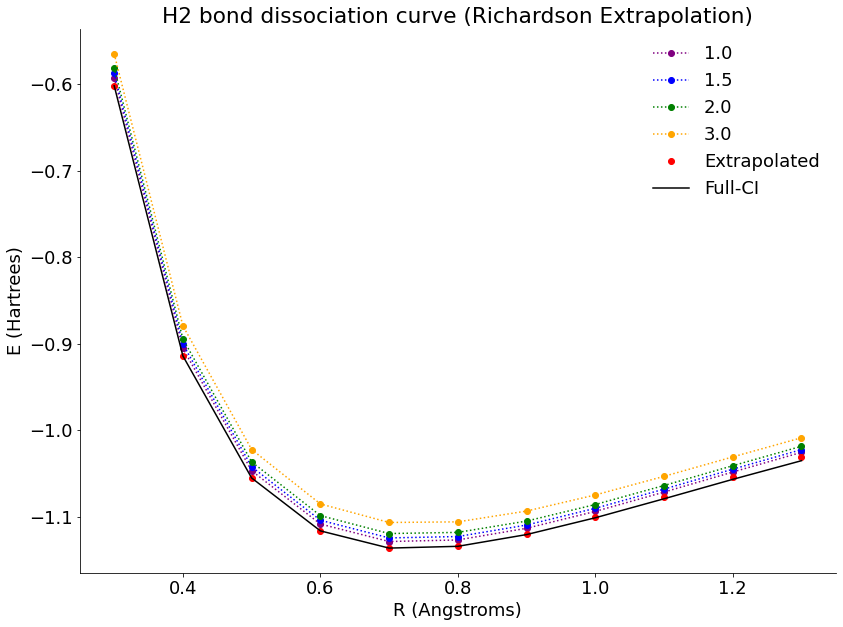

In [11]:
import matplotlib
import matplotlib.pyplot as pyplot

# Plot the various energies for different bond lengths
fig = pyplot.figure(figsize=(15,10))
pyplot.rcParams['font.size']=18
bkcolor = '#ffffff'
ax = fig.add_subplot(1, 1, 1)
pyplot.subplots_adjust(left=.2)
ax.set_xlabel('R (Angstroms)')
ax.set_ylabel(r'E (Hartrees)')
ax.set_title(r'H2 bond dissociation curve (Richardson Extrapolation)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
bond_lengths = [float(x) for x in bond_lengths]
ax.plot(bond_lengths, optimized_energies[0], linestyle=':', marker='o', label='1.0', color='purple')
ax.plot(bond_lengths, optimized_energies[1], linestyle=':', marker='o', label='1.5', color='blue')
ax.plot(bond_lengths, optimized_energies[2], linestyle=':', marker='o', label='2.0', color='green')
ax.plot(bond_lengths, optimized_energies[3], linestyle=':', marker='o', label='3.0', color='orange')
ax.plot(bond_lengths, zero_noise, 'o', label='Extrapolated', color= 'red')
ax.plot(bond_lengths, exact_energies, '-', label='Full-CI', color='black')

ax.legend(frameon=False)
pyplot.show()

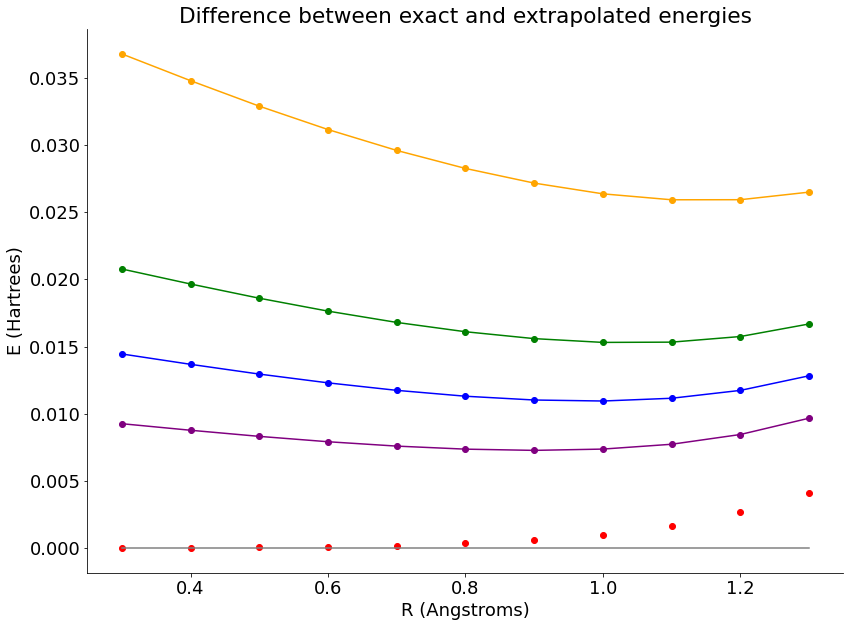

In [12]:
diff = np.absolute(exact_energies - zero_noise)
diff1 = np.zeros(len(exact_energies))
diff2 = np.zeros(len(exact_energies))
diff3 = np.zeros(len(exact_energies))
diff4 = np.zeros(len(exact_energies))
for i in range(len(optimized_energies[0])):
    diff1[i] = np.absolute(exact_energies[i] - optimized_energies[0][i])
    diff2[i] = np.absolute(exact_energies[i] - optimized_energies[1][i])
    diff3[i] = np.absolute(exact_energies[i] - optimized_energies[2][i])
    diff4[i] = np.absolute(exact_energies[i] - optimized_energies[3][i])

# Plot the various energies for different bond lengths
fig = pyplot.figure(figsize=(15,10))
pyplot.rcParams['font.size']=18
bkcolor = '#ffffff'
ax = fig.add_subplot(1, 1, 1)
pyplot.subplots_adjust(left=.2)
ax.set_xlabel('R (Angstroms)')
ax.set_ylabel(r'E (Hartrees)')
ax.set_title(r'Difference between exact and extrapolated energies')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
bond_lengths = [float(x) for x in bond_lengths]
ax.plot(bond_lengths, diff, 'o', color='red', label='Extrapolated')
ax.plot(bond_lengths, diff1, marker='o', color='purple', label='1.0')
ax.plot(bond_lengths, diff2, marker='o', color='blue', label='1.25')
ax.plot(bond_lengths, diff3, marker='o', color='green', label='1.5')
ax.plot(bond_lengths, diff4, marker='o', color='orange', label='2.0')
ax.plot(bond_lengths, np.zeros(len(bond_lengths)), '-', color='gray')

pyplot.show()
